In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from quetzal.model import stepmodel

# Modelling step assignment
## Needs LoS tables and logit probabilities
## Saves loaded network

In [3]:
input_path = '../input/'
network_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [4]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')

In [20]:
sm.segments = [('Fz'+str(p), car) for p in [1,2,3,4,6] for car in [0,1]]
#sm.segments = ['Fz'+str(p) for p in [1,2,3,4,6]]

In [6]:
v = stepmodel.read_json(model_path + 'de_volumes')
sm.volumes = v.volumes

In [7]:
# Rename columns that were confused through json export
sm.volumes = sm.volumes.rename(columns={str(seg): seg for seg in sm.segments})

In [8]:
road = stepmodel.read_json(network_path + 'de_road_network')
sm.road_links = road.road_links

In [9]:
car = stepmodel.read_json(model_path + 'de_road_los')
pt = stepmodel.read_json(model_path + 'de_pt_los')

In [21]:
# Rename columns that were confused through json export
column_dict = {"('"+str(seg)+"', 'probability')": (seg, 'probability') for seg in sm.segments}
sm.pt_los = pt.pt_los.rename(columns=column_dict)
sm.car_los = car.car_los.rename(columns=column_dict)

In [11]:
# Make path to tuples as workaround for pandas TypeError
# (see issue: https://github.com/pandas-dev/pandas/issues/31177)
sm.pt_los['link_path'] = sm.pt_los['link_path'].apply(lambda p: tuple(p))
sm.car_los['link_path'] = sm.car_los['link_path'].apply(lambda p: tuple(p))

In [22]:
sm.pt_los.sample(2)

,access_time,accessibility,destination,footpath_time,in_vehicle_time,length,link_path,mode_utility,ntransfers,origin,...,"('Fz1', 'utility')","('Fz2', 'utility')","('Fz3', 'utility')","('Fz4', 'utility')","('Fz6', 'utility')","(Fz1, probability)","(Fz2, probability)","(Fz3, probability)","(Fz4, probability)","(Fz6, probability)"
index,,,,,,,,,,,,,,,,,,,,,
259962,2186.0,NaN,DEF0A,231.0,15558.0,414446,"[r_s_4639, r_s_4640, r_s_4641, r_s_4642, r_s_4...",-2.437387,3,DE409,...,-7.091182,-3.878021,-8.232972,-5.670944,-5.825580,0.020392,0.082935,0.008558,0.023076,0.023365
600866,1179.0,NaN,DE221,300.0,17754.0,462149,"[bus_2057126, bus_721660, bus_721666, bus_7216...",-2.437387,4,DEC06,...,-7.844998,-4.352605,-9.012804,-6.135381,-6.288213,0.031039,0.145522,0.013835,0.029108,0.031494


In [23]:
# Concat the LoS tables
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index()

In [24]:
# Validate that probabilities sum up to one
sm.los.groupby(['origin', 'destination']).sum()[
    [(seg, 'probability') for seg in sm.segments]].mean(axis=1).mean()

origin  destination
DE111   DE112          1.0
        DE113          1.0
        DE114          1.0
        DE115          1.0
        DE116          1.0
                      ... 
DEG0P   DEG0J          1.0
        DEG0K          1.0
        DEG0L          1.0
        DEG0M          1.0
        DEG0N          1.0
Length: 160399, dtype: float64

## Assignment

In [25]:
# The current volumes table contains outward and return trips per OD pair.

In [26]:
# Generate loaded links and nodes from pt_los and volumes
sm.segmented_pt_assignment(split_by='route_type', on_road_links=False, path_column='link_path')

Fz6: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [03:03<00:00, 36.69s/it]


In [27]:
# Generate road_links loads from car_los and volumes
sm.segmented_car_assignment()

Fz6: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.22s/it]


In [28]:
# Assign volumes to LoS path table
sm.compute_los_volume(keep_segments=True)

## Results

In [29]:
sm.loaded_links.loc[sm.loaded_links['load']!=0].sample()

,route_type,geometry,a,b,link_sequence,route_id,time,trip_id,"(load, bus)","(load, rail)","(load, air)","(load, walk)",load
index,,,,,,,,,,,,,
r_s_113700,rail_short,"LINESTRING (8.16796 49.56438, 8.18145 49.53716)",r_s_n_9577,r_s_n_11386,7,rail_short_59,180,rail_short_28040,0.0,73348.396698,0.0,0.0,73348.396698


In [30]:
sm.road_links.loc[sm.road_links[('all', 'car')]!=0].sample()

,a,b,maxspeed,length,time,geometry,lanes,"(Fz1, car)","(Fz2, car)","(Fz3, car)","(Fz4, car)","(Fz6, car)","(all, car)"
index,,,,,,,,,,,,,
rl_78383,11132910,8391810651,68,68,4,"LINESTRING (7.26620 51.18986, 7.26563 51.18935)",None,124097.269617,19361.119224,249236.191086,290375.715142,621314.139657,1.304384e+06


In [31]:
sm.los.sample()

,index,access_time,accessibility,destination,footpath_time,in_vehicle_time,length,link_path,mode_utility,ntransfers,...,"(Fz2, probability)","(Fz3, probability)","(Fz4, probability)","(Fz6, probability)",Fz1,Fz2,Fz3,Fz4,Fz6,volume
107812,107812,1344.0,NaN,DE252,0.0,15300.0,279181,"[coach_4138, coach_4139, coach_3673, coach_367...",-3.321016,1,...,0.173816,0.007888,0.007353,0.013944,0.0,0.0,0.0,5.786961,51.092442,56.879403


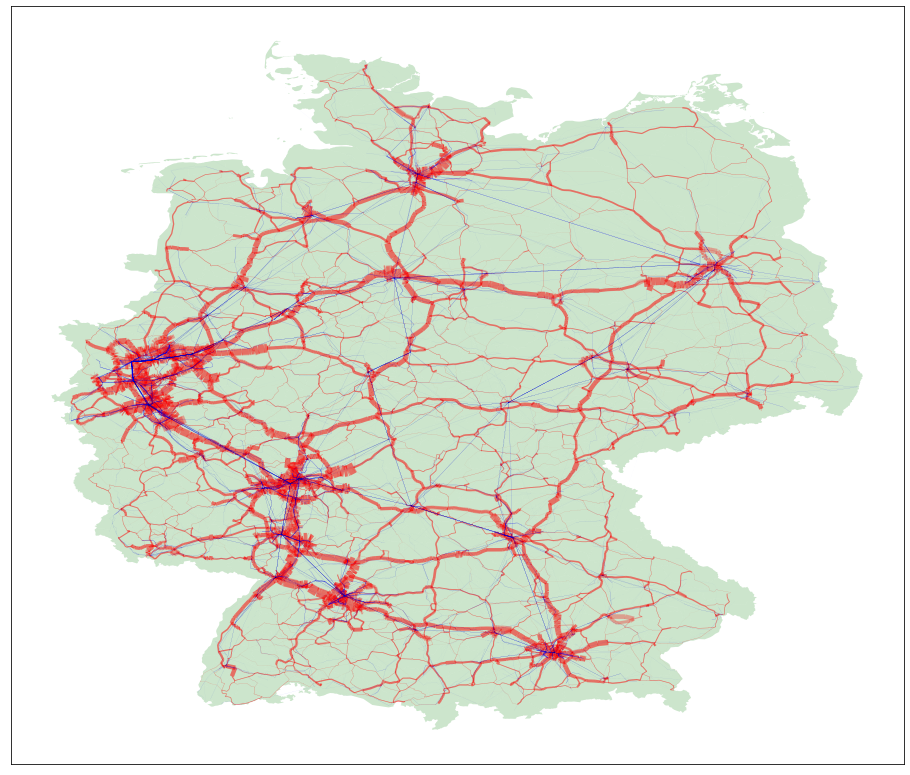

In [32]:
# Plot road and PT assignment
sm.loaded_links = gpd.GeoDataFrame(sm.loaded_links)
sm.road_links = gpd.GeoDataFrame(sm.road_links)
scaler = max(sm.loaded_links['load'].max(), sm.road_links[('all', 'car')].max()) / 35
sm.loaded_links.plot(alpha=.3, color='blue', linewidth=list(sm.loaded_links['load']/scaler),
    ax=sm.road_links.plot(alpha=.3, color='red', linewidth=list(sm.road_links[('all', 'car')]/scaler),
        ax=sm.plot('zones', alpha=.2, color='green', figsize=(16,16))))
plt.savefig(output_path + 'figures/network_load_all.png', dpi=300)

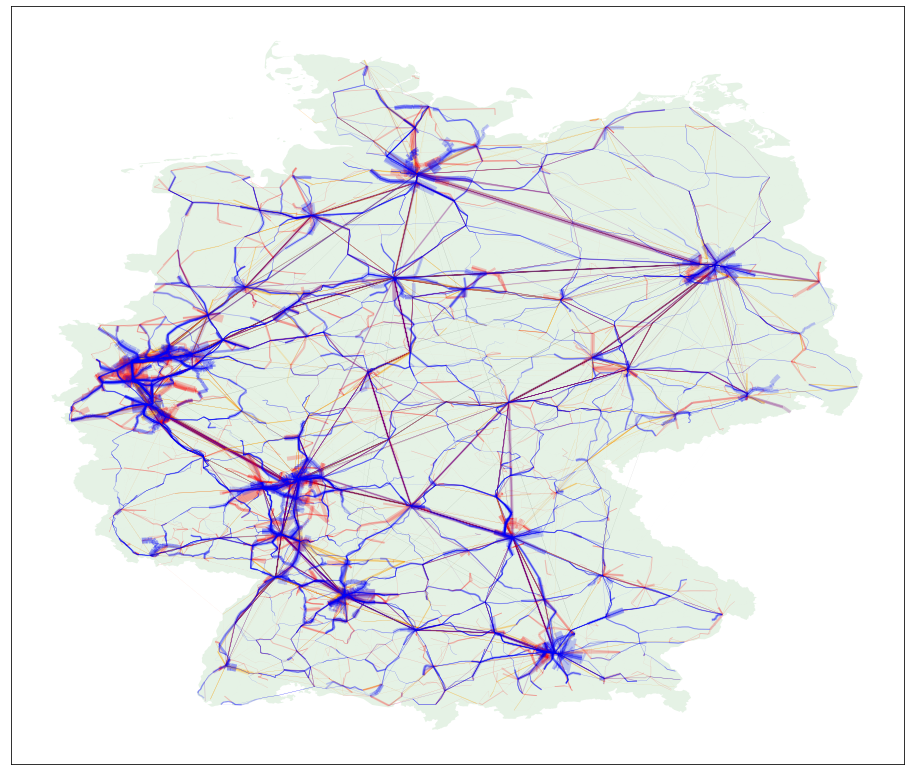

In [33]:
# Only PT
colors = sm.loaded_links['route_type'].map(
    {'rail': 'blue', 'rail_long': 'purple', 'rail_short': 'blue',
     'bus': 'red', 'subway': 'red', 'tram': 'red', 'ferry': 'red', 'funicular': 'red',
     'coach': 'orange', 'air': 'black', 'walk': 'grey'})
sm.loaded_links.plot(alpha=.2, color=list(colors),
    linewidth=list(sm.loaded_links['load']/sm.loaded_links['load'].max()*35),
    ax=sm.plot('zones', alpha=.1, color='green', figsize=(16,16)))
plt.savefig(output_path + 'figures/network_load_pt.png', dpi=300)

### Validation

In [34]:
# Total difference between volumes and loads
vol = sm.volumes.set_index(['origin', 'destination']).sum(axis=1).rename('vol')
diff = sm.los.groupby(['origin', 'destination']).agg({'volume': 'sum'}).merge(
    vol, left_index=True, right_index=True)
diff['diff'] = diff['vol'] - diff['volume']

In [35]:
diff['diff'].mean()

2.2816867321017848e-07

<AxesSubplot:>

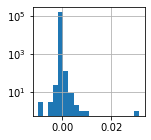

In [36]:
diff['diff'].hist(bins=20, log=True, figsize=(2,2))

In [37]:
# Summary of LoS table volumes
od_sum = sm.summary_od(costs=[])

In [38]:
od_sum.sample()

,,segment,Fz1,Fz2,Fz3,Fz4,Fz6,root
,,sum,volume,volume,volume,volume,volume,volume
origin,destination,mode,,,,,,
DE124,DEA33,rail,0.0,0.0,0.0,209.914078,299.320027,509.234105


In [39]:
# Add averages from following attributes
attrs = ['price', # EUR per person
         'time', # hours per trip
         'in_vehicle_time', # seconds per ride
         'length', # Meter distance
         'ntransfers'] # per trip
means = sm.los.groupby(['origin', 'destination', 'route_type'])[attrs].mean()
for attr in attrs:
    od_sum[('root', attr)] = means[attr]

In [40]:
# Convert units
od_sum[('root', 'length')] /= 1000
od_sum[('root', 'in_vehicle_time')] /= 3600

In [41]:
# Compute passenger kilometer
for seg in sm.segments + ['root']:
    od_sum[(seg, 'pkm')] = od_sum[(seg, 'volume')] * od_sum[('root', 'length')]

In [42]:
# Load calibration dataset for modal split validation
mid2017 = pd.read_csv(network_path + 'mid2017_validation_normalised.csv')
mid2017.set_index('mode_model', drop=True, inplace=True)
mode_dict_mid = {1: 'rail', 2: 'rail',
                 3: 'bus', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
mid2017['mode_agg'] = [mode_dict_mid[i] for i in mid2017.index]

array([<AxesSubplot:ylabel='1'>, <AxesSubplot:ylabel='2'>,
       <AxesSubplot:ylabel='3'>, <AxesSubplot:ylabel='4'>,
       <AxesSubplot:ylabel='6'>], dtype=object)

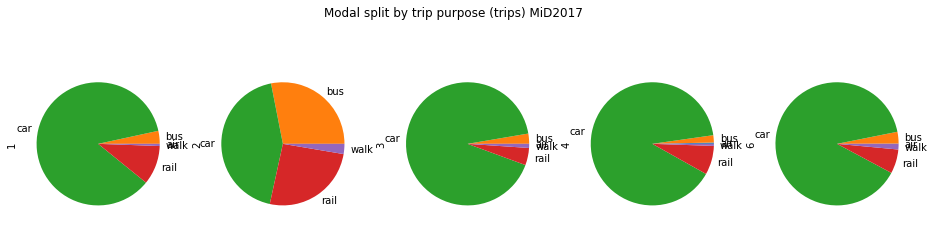

In [43]:
mid2017.groupby('mode_agg').sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False,
    title='Modal split by trip purpose (trips) MiD2017')

array([<AxesSubplot:ylabel='Fz1'>, <AxesSubplot:ylabel='Fz2'>,
       <AxesSubplot:ylabel='Fz3'>, <AxesSubplot:ylabel='Fz4'>,
       <AxesSubplot:ylabel='Fz6'>], dtype=object)

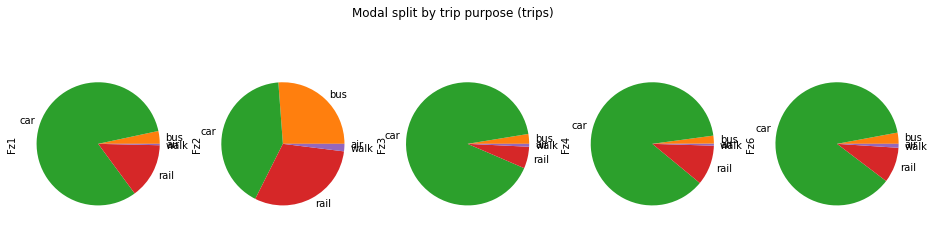

In [44]:
od_sum.loc[:, [(seg, 'volume') for seg in sm.segments]].groupby(level=2).sum(axis=1).plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (trips)')
plt.savefig(output_path + 'figures/modal_split_trips_segmented.png', dpi=300)

In [45]:
# MiD mode shares in percent
(mid2017.groupby('mode_agg').sum() / mid2017[['1','2','3','4','6']].sum() * 100).round(2)

,1,2,3,4,6
mode_agg,,,,,
air,0.00,0.00,0.01,0.35,0.05
bus,3.40,28.10,2.67,1.90,3.10
car,85.75,43.49,91.72,89.62,89.03
rail,10.28,25.75,4.53,7.59,6.34
walk,0.57,2.66,1.08,0.54,1.48


In [46]:
# Model mode shares in percent
(od_sum.loc[:, [(seg, 'volume') for seg in sm.segments]].groupby(level=2).sum(axis=1) /
 od_sum.loc[:, [(seg, 'volume') for seg in sm.segments]].sum().droplevel('sum') * 100).round(2)

,Fz1,Fz2,Fz3,Fz4,Fz6
mode,,,,,
air,0.00,0.00,0.00,0.04,0.00
bus,3.36,26.17,2.58,2.09,2.93
car,81.74,41.43,90.96,86.89,86.74
rail,14.54,30.44,5.71,10.49,9.30
walk,0.37,1.96,0.76,0.49,1.03


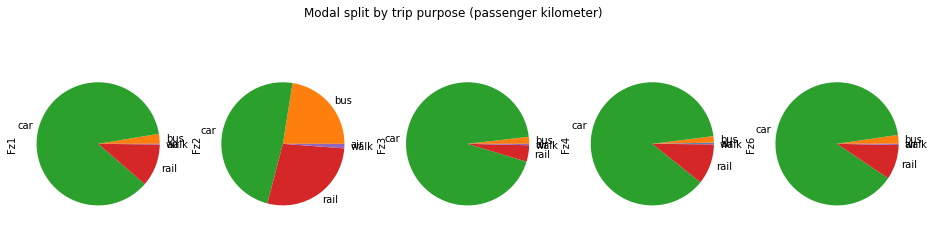

In [48]:
od_sum.loc[:, [(seg, 'pkm') for seg in sm.segments]].groupby(level=2).sum(axis=1).plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (passenger kilometer)')
plt.savefig(output_path + 'figures/modal_split_pkm_segmented.png', dpi=300)

In [58]:
# Load VP2030 data for validation
vp2017 = pd.read_csv(network_path + 'vp2017_validation_normalised.csv')
# Restrict to inter-cell traffic and cells of the model
vp2017 = vp2017.loc[(vp2017['origin']!=vp2017['destination']) &
                    (vp2017['origin'].notna()) &
                    (vp2017['destination'].notna())]
vp2017 = vp2017.groupby(['origin', 'destination']).sum()
mode_dict_vp = {'Bahn': 'rail', 'MIV': 'car', 'Luft': 'air', 'OESPV': 'bus', 'non': 'walk'}
vp2017.columns = pd.MultiIndex.from_tuples(
    [(col.split('_')[-1], mode_dict_vp[col.split('_')[0]]) for col in vp2017.columns],
    names=['segment', 'mode'])

In [83]:
# Define distance classes
bins = [0, 10, 20, 30, 40, 50, 60, 80, 100, 150, 200, 500, 1000]
distances = sm.car_los.drop_duplicates(['origin', 'destination']).set_index(
    ['origin', 'destination'])['length'] / 1000
labels = ['{}-{}km'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)]

In [84]:
# Normalise model volumes
od = od_sum[[(seg, 'volume') for seg in sm.segments]
           ].unstack('mode').fillna(0).droplevel('sum', axis=1)
od = (od-od.min())/(od.max()-od.min()).max()

In [85]:
# Cut matrices into distance classes
od['bins'] = pd.cut(od.merge(distances, how='left', left_index=True, right_index=True)['length'],
                    bins=bins, labels=labels)
vp2017['bins'] = pd.cut(vp2017.merge(distances, how='left', left_index=True, right_index=True)['length'],
                        bins=bins, labels=labels)

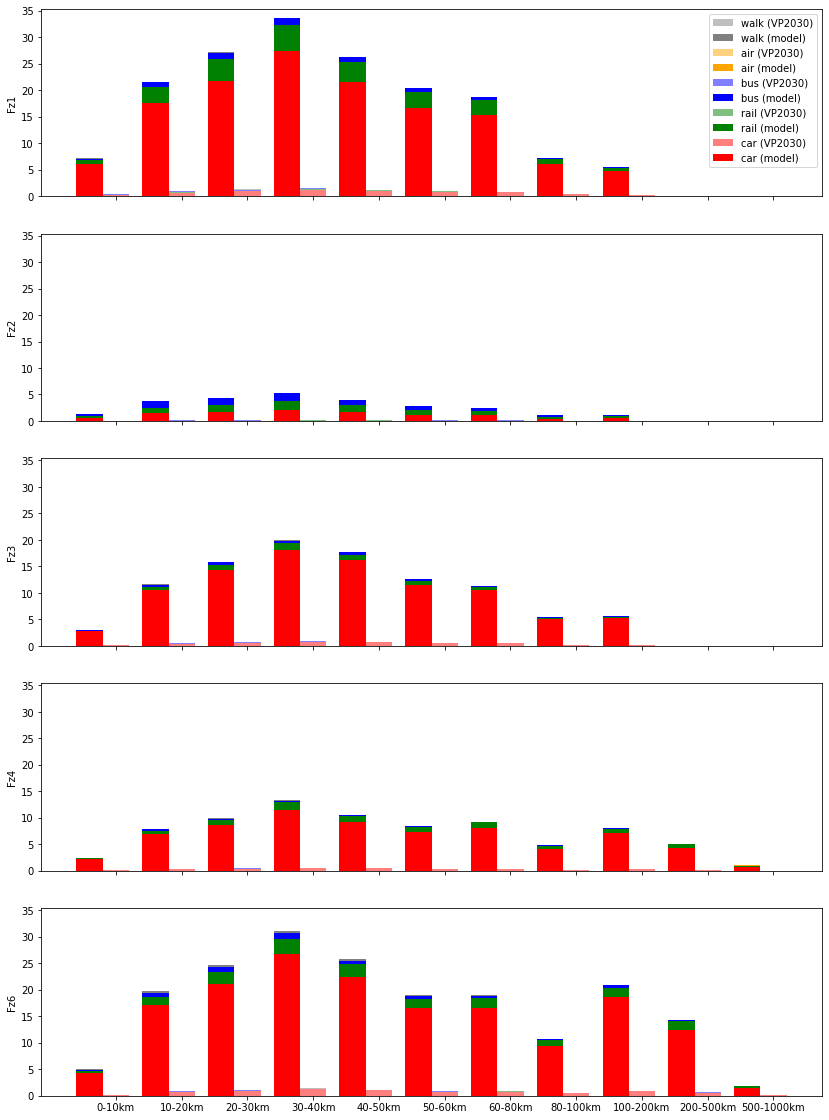

In [99]:
# Plot distance and mode distribution by segment
fig, ax = plt.subplots(nrows=len(sm.segments), ncols=1,
                       figsize=(14,len(sm.segments)*4),
                       sharex='all', sharey='all')
width = 0.4
ind = np.arange(len(labels))
modes = ['car', 'rail', 'bus', 'air', 'walk']
colors = ['red', 'green', 'blue', 'orange', 'grey']
od_binned = od.groupby('bins').sum()
vp_binned = vp2017.groupby('bins').sum()
for seg in range(len(sm.segments)):
    model_vols = [od_binned[(sm.segments[seg], mode)] for mode in modes]
    vp_vols = [vp_binned[(sm.segments[seg], mode)] for mode in modes]
    for i in range(len(modes)):
        if i==0:
            model_bottom = 0
            vp_bottom = 0
        else:
            model_bottom = sum(model_vols[:i])
            vp_bottom = sum(vp_vols[:i])
        ax[seg].bar(ind, np.array(model_vols[i]), bottom=model_bottom,
                    width=width, tick_label=labels, color=colors[i], label=modes[i]+' (model)')
        ax[seg].bar(ind+width, np.array(vp_vols[i]), bottom=vp_bottom, alpha=.5,
                    width=width, tick_label=labels, color=colors[i], label=modes[i]+' (VP2030)')
    ax[seg].set_ylabel(sm.segments[seg])
h, l = ax[0].get_legend_handles_labels()
ax[0].legend(h[::-1], l[::-1])
#plt.savefig(output_path + 'figures/distance_validation.png', dpi=300)

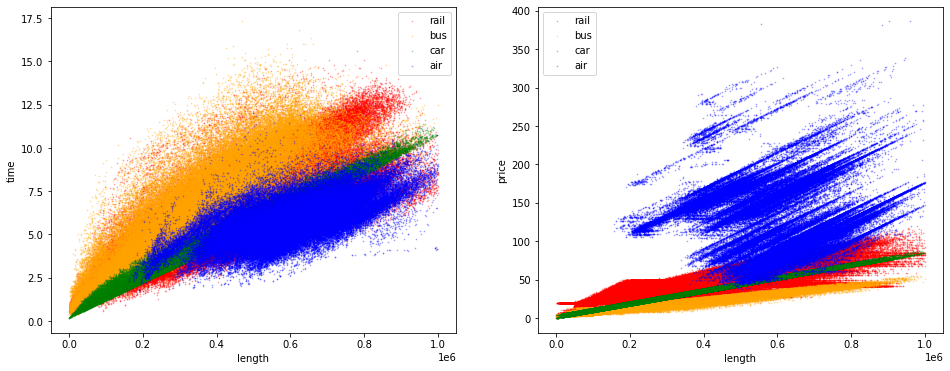

In [39]:
# How do the LoS attributes look like again?
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
c_dict = {'rail': 'red', 'bus': 'orange', 'car': 'green', 'air': 'blue'}
sm.los['length'] = sm.los['length'] / 1000
for m in c_dict.keys():
    sm.los.loc[sm.los['route_type']==m].plot(
        ax=ax[0], kind='scatter', x='length', y='time', s=.5, c=c_dict[m], alpha=.3, label=m)
    sm.los.loc[sm.los['route_type']==m].plot(
        ax=ax[1], kind='scatter', x='length', y='price', s=.5, c=c_dict[m], alpha=.3, label=m)
plt.legend()
plt.savefig(output_path + 'figures/LoS_attributes.png', dpi=300)
sm.los['length'] = sm.los['length'] * 1000

### Excel export

What do we need as outputs for energy and emission modelling? Most commonly, energy system models minimise total system cost under the constraint of emissions reduction towards a given goal. Costs include investments into vehicles (sometimes even infrastructure) and operating cost of these vehicles. Demand for transport is exogenously defined as activity rates per vehicle technology type in each time step. This model can contribute:
* passenger kilometer per mode and zone
* user cost, which can be translated into operating cost

In [40]:
# Keep only the aggregation of all purposes
od = od_sum.loc[:, 'root']

In [41]:
# Aggregated modal split in million pkm
od.groupby(level=2).sum(axis=1)['pkm'] / 1e6

mode
air        641.012885
bus      25221.434688
car     792817.292672
rail     88126.441886
walk      2565.930138
Name: pkm, dtype: float64

In [42]:
# Reduce table size by mapping origin and destination to bigger zones
od.reset_index(drop=False, inplace=True)
od['origin'] = od['origin'].str[:3] # NUTS1
od['destination'] = od['destination'].str[:3]

In [43]:
# Calculate weighted averages by zone aggregation
weighted_av = lambda x: np.average(x, weights=od.loc[x.index, 'volume'])
od = od.groupby(['origin', 'destination', 'mode']).agg(
    volumes=('volume', 'sum'),
    price=('price', weighted_av),
    time=('time', weighted_av),
    in_vehicle_time=('in_vehicle_time', weighted_av),
    length=('length', weighted_av))

In [44]:
with pd.ExcelWriter(output_path + 'inter_zone.xlsx') as writer:  
    od.to_excel(writer, sheet_name='od')

## Save model

In [45]:
sm.to_json(model_path + 'de_assignment', only_attributes=[
    'loaded_links', 'loaded_nodes', 'road_links'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 38/38 [03:21<00:00,  5.29s/it]
